# COVID-19 MS-LR models

# Preparation

## Load libraries

In [1]:
import numpy as np
import pandas as pd 
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from datetime import datetime

import warnings

import statsmodels.api as sm

from pathlib import Path

## Load and prepare data

In [2]:
df = pd.read_excel("BelarusWeeklyAVG.xlsx", index_col=[0], engine='openpyxl')
df.index = df.index.to_series().apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
df.dropna().tail(15)

,Confirmed,Active,Deaths,Recovered,Closed
Date,,,,,
2022-01-21,718371.000000,1285.000000,5853.000000,711233.000000,717086.000000
2022-01-28,730465.000000,1845.428571,5962.000000,722657.571429,728619.571429
2022-02-04,747179.714286,3864.714286,6068.714286,737246.285714,743315.000000
2022-02-11,790823.142857,6790.714286,6175.428571,777857.000000,784032.428571
2022-02-18,845271.000000,8322.714286,6281.428571,830666.857143,836948.285714
2022-02-25,891919.142857,7513.571429,6391.714286,878013.857143,884405.571429
2022-03-04,921173.000000,4434.000000,6494.142857,910244.857143,916739.000000
2022-03-11,933278.857143,1307.428571,6592.571429,925378.857143,931971.428571
2022-03-18,943716.857143,8502.285714,6678.571429,928536.000000,935214.571429


In [3]:
data = pd.concat(
    [df["Closed"].rename("closed"), (df["Closed"] - df["Closed"].tshift(1)).rename("dclosed"), df["Active"].rename("active"), (df["Active"] - df["Active"].tshift(1)).rename("dactive")],
    axis="columns",
).dropna(axis="rows")
data["c"] = 1
data["t"] =  range(len(data))
pd.concat([data.head(), data.tail()])

C:\Users\Valery\AppData\Local\Temp/ipykernel_14284/709386458.py:2: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  [df["Closed"].rename("closed"), (df["Closed"] - df["Closed"].tshift(1)).rename("dclosed"), df["Active"].rename("active"), (df["Active"] - df["Active"].tshift(1)).rename("dactive")],


,closed,dclosed,active,dactive,c,t
Date,,,,,,
2020-02-28,0.000000,0.000000,0.142857,0.142857,1,0
2020-03-06,0.000000,0.000000,3.571429,3.428571,1,1
2020-03-13,1.714286,1.714286,10.285714,6.714286,1,2
2020-03-20,5.285714,3.571429,37.142857,26.857143,1,3
2020-03-27,23.428571,18.142857,59.428571,22.285714,1,4
2022-04-01,935337.571429,62.285714,25472.000000,7650.714286,1,109
2022-04-08,935390.285714,52.714286,31013.428571,5541.428571,1,110
2022-04-15,935417.857143,27.571429,35761.142857,4747.714286,1,111
2022-04-22,935445.142857,27.285714,39830.857143,4069.714286,1,112


 gdp_decomp.to_excel("filter.xlsx")

In [4]:
endog = data['dactive']
exog = data[['c', 'dclosed','t']]

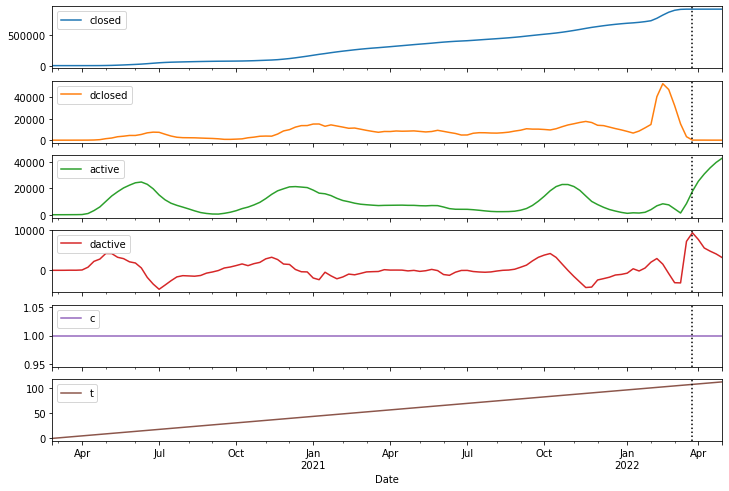

In [5]:
cutoff = '2022-03-25'  #
gdp_decomp = data[['active']]
cutoff_idx = np.argmax(gdp_decomp.index == cutoff)
train = data.index[:cutoff_idx]
valid = data.index[cutoff_idx:]
axs = data.plot.line(subplots=True, figsize=(12, 8))
for ax in axs:
    ax.axvline(cutoff, linestyle=':', color='black')

# MS-LR

## Create model

In [6]:
np.random.seed(22)

model_template = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=2, exog=exog,  trend=None, switching_exog = True,
)

# Fit model only train data
mdl_sm = None
remaining_tries = 100
with warnings.catch_warnings():
    warnings.simplefilter("error", RuntimeWarning)
    while (mdl_sm is None) and (remaining_tries >= 0):
        print(remaining_tries)
        try:
            mdl_sm = sm.tsa.MarkovRegression(
                endog=endog.loc[train],
                k_regimes=2,
                exog=exog.loc[train],
                switching_exog = True,
                trend=None
            ).fit(search_reps=1000, em_iter=10, disp=True)
        except RuntimeWarning:
            remaining_tries -= 1

# Get coefficients
coef_sm = pd.DataFrame(
    {
        "value": mdl_sm.params,
        "std": pd.Series(np.sqrt(np.diag(mdl_sm.cov_params())), mdl_sm.params.index),
        "z": mdl_sm.tvalues,
    }
)

100
Optimization terminated successfully.
         Current function value: 8.654654
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31


## Get dataframe of predictions

In [7]:
pred_ins = pd.Series(
    mdl_sm.predict(),
    index=train,
    name="Conditional Mean (In-sample)",
)

pred_oos = pd.Series(
    model_template.predict(mdl_sm.params, start=cutoff),
    index=valid,
    name="OOS Mean",
)

# Conditional prediction
pred_cond = pd.DataFrame(
    model_template.predict(params = mdl_sm.params, conditional=True)[:, cutoff_idx:].T,
    index=valid,
    columns=["OOS (Regime 0)", "OOS (Regime 1)"],
)
pred_all = pd.concat([pred_ins, pred_oos], axis="rows")

df_sm = pd.DataFrame(
    {
        "actual": endog,
        "pred": pred_all,
        "resid": endog - pred_all,
        "prob_raw": pd.Series(
            mdl_sm.predicted_marginal_probabilities[0], index=train
        ),
        "prob_filtered": mdl_sm.filtered_marginal_probabilities[0],
        "prob_smoothed": mdl_sm.smoothed_marginal_probabilities[0],
        
    }
)

C:\Users\Valery\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


## Overview

In [8]:
pred_cond.to_excel("ActiveEndogCondSwitchingOn.xlsx")
coef_sm.to_excel("ActiveEndogParamsSwitchingOn.xlsx")
df_sm.to_excel("ActiveEndogSwitchingOn.xlsx")

In [9]:
mdl_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                dactive   No. Observations:                  108
Model:               MarkovRegression   Log Likelihood                -934.703
Date:                Sun, 19 Jun 2022   AIC                           1887.405
Time:                        14:56:35   BIC                           1911.544
Sample:                    02-28-2020   HQIC                          1897.193
                         - 03-18-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c           2132.6549    443.424      4.810      0.000    1263.559    3001.750
dclosed       -0.0787      0.022     -3.542      0.000      -0.122      -0.035
t             22.3207      8.746      2.552      0.011       5.178      39.463
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c           -344.0356    299.433     -1.149      0.251    -930.913     242.842
dclosed       -0.1745      0.033     -5.362      0.000      -0.238      -0.111
t             17.1683      6.116      2.807      0.005       5.181      29.155
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.244e+06   1.77e+05      7.049      0.000    8.98e+05    1.59e+06
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8493      0.067     12.617      0.000       0.717       0.981
p[1->0]        0.0611      0.027      2.274      0.023       0.008       0.114
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot:xlabel='Date'>

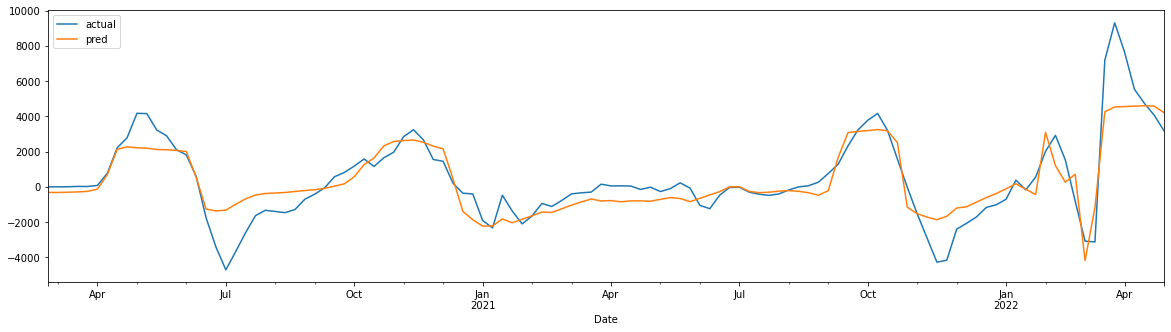

In [10]:
ax = df_sm[['actual', 'pred']]

ax.plot(figsize=(20,5))

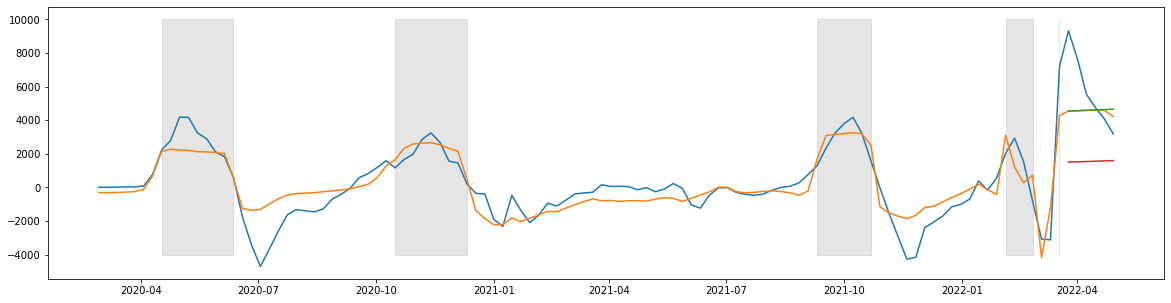

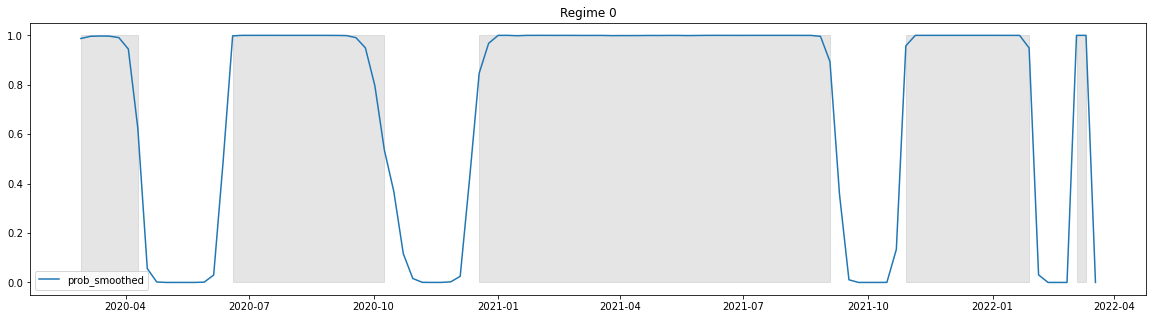

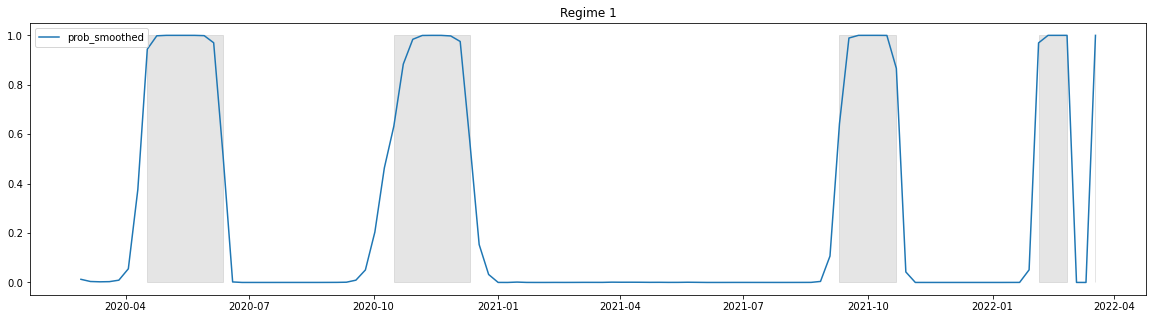

In [11]:
DF = pd.concat([df_sm[['actual', 'pred']],pred_cond[['OOS (Regime 0)', 'OOS (Regime 1)']]],axis="columns")
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(DF)
ax.fill_between(df_sm['prob_smoothed'].index, -4000, 10000,where= (((df_sm['prob_smoothed'] > 0.5))) , color='gray', alpha=0.2)


fig, ax = plt.subplots(figsize=(20,5))

ax.plot(1-df_sm[['prob_smoothed']], label = 'prob_smoothed')
ax.legend()
ax.fill_between(df_sm['prob_smoothed'].index, 0, 1, where= (( (df_sm['prob_smoothed'] < 0.5))), color='gray', alpha=0.2)
ax.set(title='Regime 0');


fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df_sm[['prob_smoothed']], label = 'prob_smoothed')
ax.legend()
ax.fill_between(df_sm['prob_smoothed'].index, 0, 1, where = (((df_sm['prob_smoothed'] > 0.5))), color='gray', alpha=0.2)
ax.set(title='Regime 1');

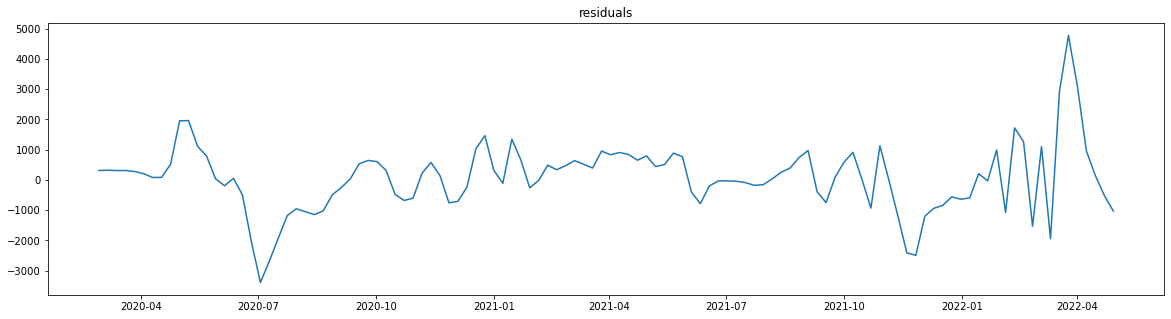

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_sm['resid'])
ax.set(title='residuals');

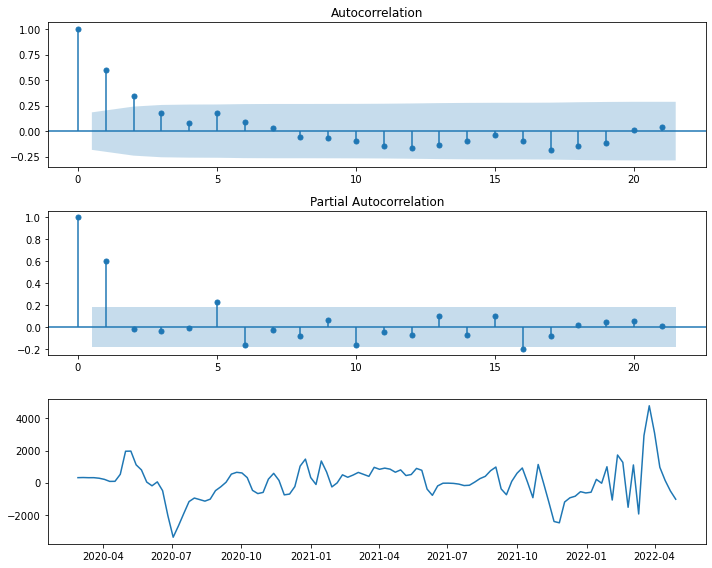

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
sm.tsa.graphics.plot_acf(df_sm['resid'], ax=ax[0])
sm.tsa.graphics.plot_pacf(df_sm['resid'], ax=ax[1])
ax[2].plot(df_sm['resid'])

fig.tight_layout()
fig.savefig("m0r.png");

# MS-LR-AR

## Estimate MS-LR residials by LS

In [14]:
def getResid(beta):
    return df_sm['resid'].tail(len(df_sm['resid']))

In [15]:
from scipy.optimize import least_squares
estimate_resid = least_squares(getResid, x0 =0)

In [16]:
dactivetr = data['dactive'].rename('dactivetr') - estimate_resid.fun

<AxesSubplot:xlabel='Date'>

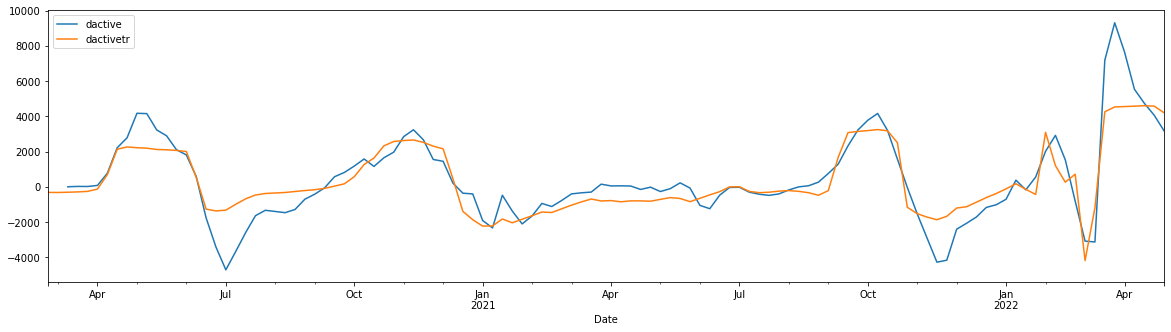

In [17]:
pd.concat([data['dactive'].tail(112), dactivetr],axis="columns").plot(figsize=(20,5))

In [18]:
dendog =  pd.concat([dactivetr], axis="columns").dropna(axis="rows")
dendog.index = dendog.index.to_series().apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
dexog = pd.concat([data['c'], data['dclosed'].tail(len(dendog))], axis="columns").dropna(axis="rows")
dexog['t'] = range(len(dendog))
dcutoff_idx = np.argmax(dendog.index == cutoff)
dtrain = dendog.index[:dcutoff_idx]
dvalid = dendog.index[dcutoff_idx:]

In [19]:
np.random.seed(22)

model_template_tr = sm.tsa.MarkovRegression(
    endog=dendog, k_regimes=2, exog=dexog,  trend=None, switching_exog = True,
)

# Fit model only train data
mdl_sm_tr = None
remaining_tries = 100
with warnings.catch_warnings():
    warnings.simplefilter("error", RuntimeWarning)
    while (mdl_sm_tr is None) and (remaining_tries >= 0):
        print(remaining_tries)
        try:
            mdl_sm_tr = sm.tsa.MarkovRegression(
                endog=dendog.loc[dtrain],
                k_regimes=2,
                exog=dexog.loc[dtrain],
                switching_exog = True,
                trend=None
            ).fit(search_reps=1000, em_iter=10, disp=True)
        except RuntimeWarning:
            remaining_tries -= 1

# Get coefficients
coef_sm_tr = pd.DataFrame(
    {
        "value": mdl_sm_tr.params,
        "std": pd.Series(np.sqrt(np.diag(mdl_sm_tr.cov_params())), mdl_sm_tr.params.index),
        "z": mdl_sm_tr.tvalues,
    }
)

# Get dataframe of predictions
pred_ins_tr = pd.Series(
    mdl_sm_tr.predict(),
    index=dtrain,
    name="Conditional Mean (In-sample)",
)
pred_oos_tr = pd.Series(
    model_template.predict(mdl_sm_tr.params, start=cutoff),
    index=dvalid,
    name="OOS Mean",
)
# Conditional prediction
pred_cond_tr = pd.DataFrame(
    model_template_tr.predict(mdl_sm_tr.params, conditional=True)[:, dcutoff_idx:].T,
    index=dvalid,
    columns=["OOS (Regime 0)", "OOS (Regime 1)"],
) 
pred_all_tr = pd.concat([pred_ins_tr, pred_oos_tr], axis="rows")

# Bunch together
df_sm_tr = pd.DataFrame(
    {
        "actual": data['dactive'],
        "pred": pred_all_tr,
        "resid": data['dactive'] - pred_all_tr,
        "prob_raw": pd.Series(
            mdl_sm_tr.predicted_marginal_probabilities[0], index=dtrain
        ),
        "prob_filtered": mdl_sm_tr.filtered_marginal_probabilities[0],
        "prob_smoothed": mdl_sm_tr.smoothed_marginal_probabilities[0],
        
       
    }
)

100


C:\Users\Valery\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.407908
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27


C:\Users\Valery\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [20]:
pred_cond_tr.to_excel("ActiveTREndogCondSwitchingOn.xlsx")
coef_sm_tr.to_excel("ActiveTREndogParamsSwitchingOn.xlsx")
df_sm_tr.to_excel("ActiveTREndogSwitchingOn.xlsx")

In [21]:
mdl_sm_tr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:              dactivetr   No. Observations:                  108
Model:               MarkovRegression   Log Likelihood                -800.054
Date:                Sun, 19 Jun 2022   AIC                           1618.108
Time:                        14:56:40   BIC                           1642.247
Sample:                    02-28-2020   HQIC                          1627.896
                         - 03-18-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c           1818.0104    107.946     16.842      0.000    1606.440    2029.581
dclosed       -0.0755      0.006    -13.009      0.000      -0.087      -0.064
t             22.8598      2.114     10.813      0.000      18.716      27.003
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c           -227.4466     78.620     -2.893      0.004    -381.539     -73.355
dclosed       -0.1768      0.009    -20.313      0.000      -0.194      -0.160
t             16.3593      1.592     10.278      0.000      13.240      19.479
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.176e+04   1.25e+04      7.312      0.000    6.72e+04    1.16e+05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8557      0.063     13.531      0.000       0.732       0.980
p[1->0]        0.0609      0.027      2.282      0.022       0.009       0.113
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot:xlabel='Date'>

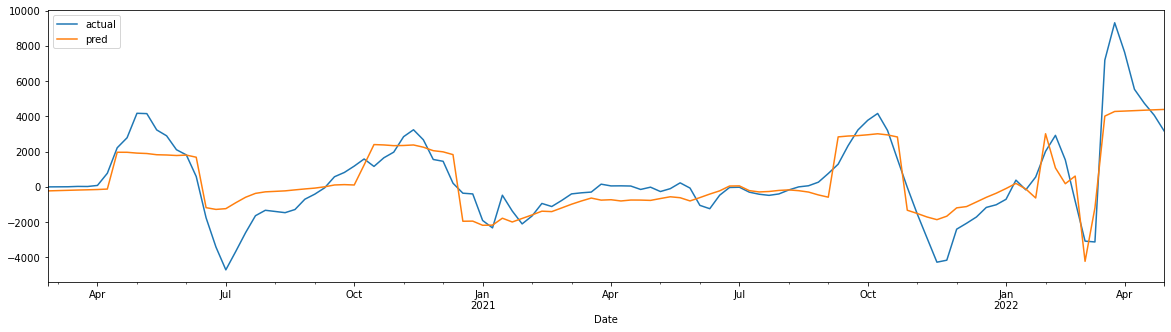

In [22]:
ax = pd.concat([df_sm_tr['actual'], df_sm_tr['pred']], axis="columns")
ax.plot(figsize=(20,5))

In [23]:
qw=pred_cond[['OOS (Regime 0)', 'OOS (Regime 1)']]

<AxesSubplot:xlabel='Date'>

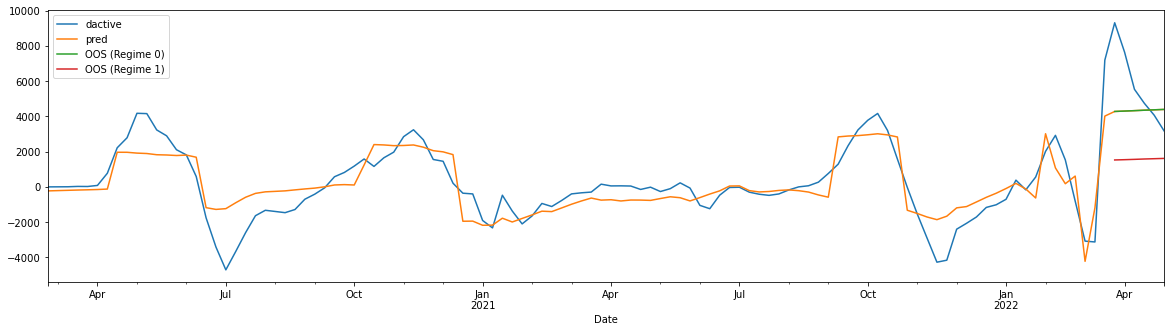

In [24]:
DF = pd.concat([data['dactive'], df_sm_tr['pred'],pred_cond_tr['OOS (Regime 0)'], pred_cond_tr['OOS (Regime 1)']],axis="columns")
DF.plot(figsize=(20,5))

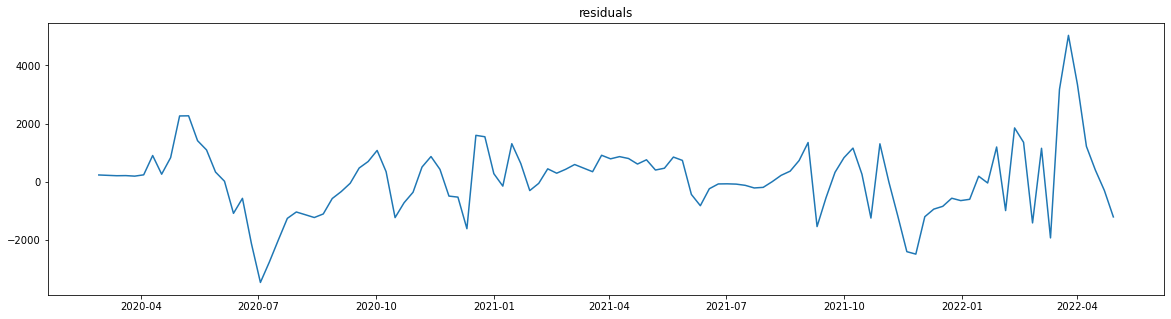

In [25]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_sm_tr['resid'])
ax.set(title='residuals');

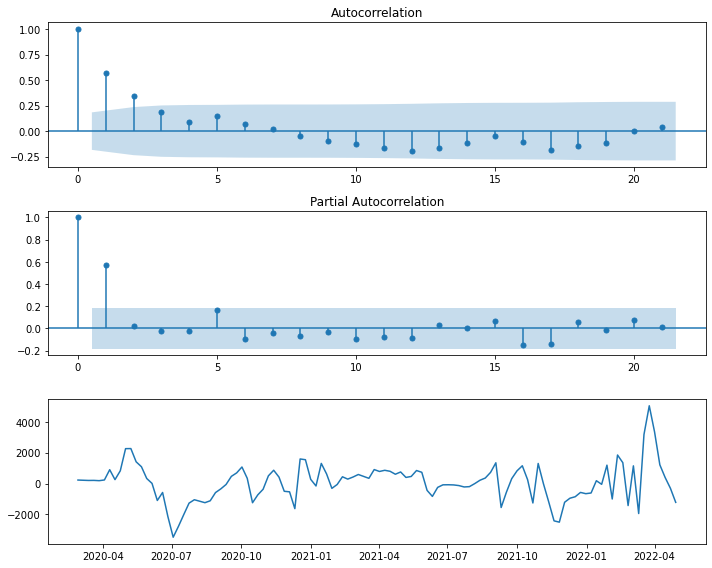

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
sm.tsa.graphics.plot_acf(df_sm_tr['resid'].dropna(), ax=ax[0])
sm.tsa.graphics.plot_pacf(df_sm_tr['resid'].dropna(), ax=ax[1])
ax[2].plot(df_sm_tr['resid'])

fig.tight_layout()
fig.savefig("m2r.png");

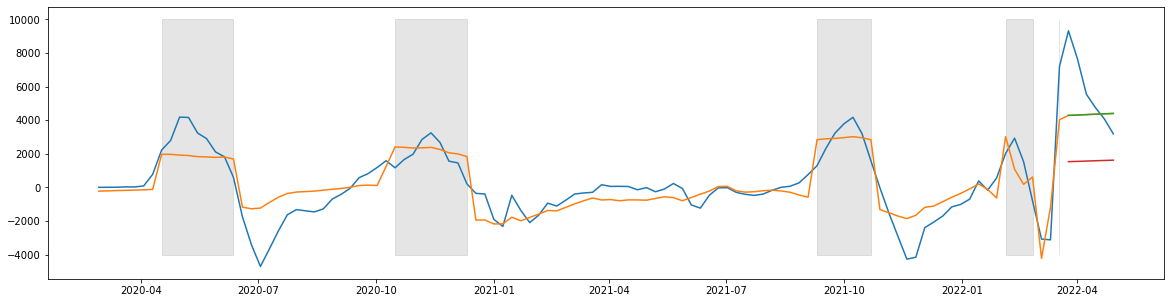

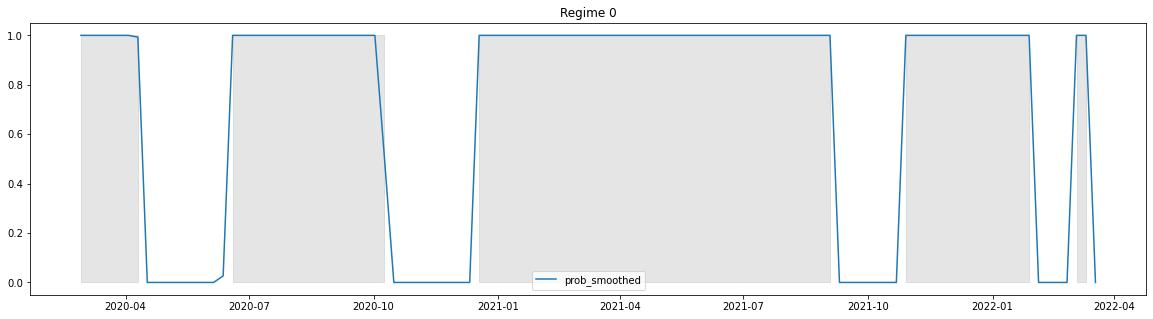

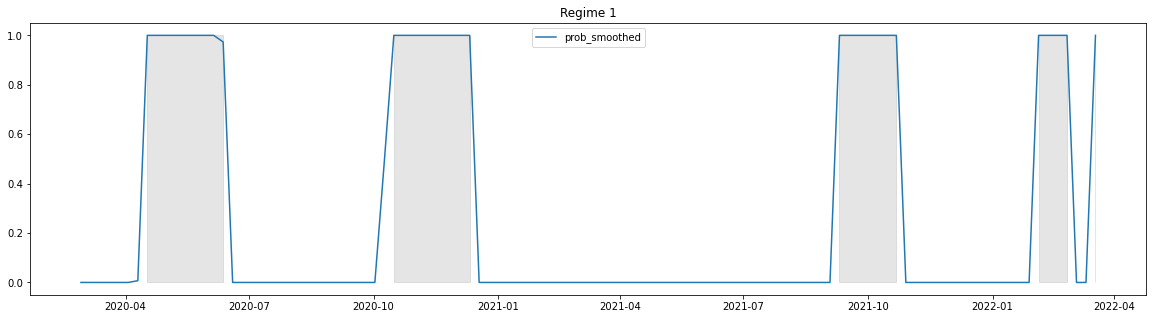

In [27]:
DF = pd.concat([df_sm_tr[['actual', 'pred']],pred_cond_tr[['OOS (Regime 0)', 'OOS (Regime 1)']]],axis="columns")
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(DF)
ax.fill_between(df_sm_tr['prob_smoothed'].index, -4000, 10000,where= (((df_sm_tr['prob_smoothed'] > 0.5))) , color='gray', alpha=0.2)

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(1-df_sm_tr[['prob_smoothed']], label = 'prob_smoothed')
ax.legend()
ax.fill_between(df_sm_tr['prob_smoothed'].index, 0, 1, where= (( (df_sm_tr['prob_smoothed'] < 0.5))), color='gray', alpha=0.2)
ax.set(title='Regime 0');


fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df_sm_tr[['prob_smoothed']], label = 'prob_smoothed')
ax.legend()
ax.fill_between(df_sm_tr['prob_smoothed'].index, 0, 1, where = (((df_sm_tr['prob_smoothed'] > 0.5))), color='gray', alpha=0.2)
ax.set(title='Regime 1');

# Hodrick-Prescottt filter

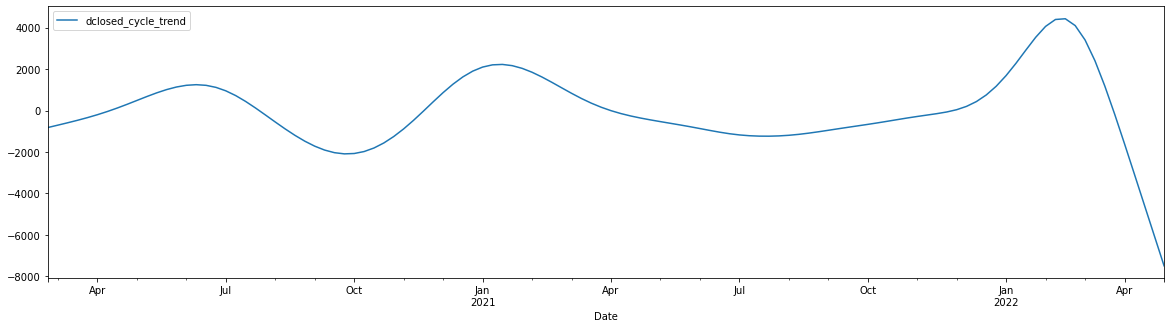

In [28]:
dclosed_cycle, dclosed_trend = sm.tsa.filters.hpfilter(data['dclosed'], 2500)
dclosed_cycle2, dclosed_trend2 = sm.tsa.filters.hpfilter(dclosed_cycle, 500)
pd.concat([dclosed_trend2], axis='columns').plot(figsize=(20,5))

plt.show()

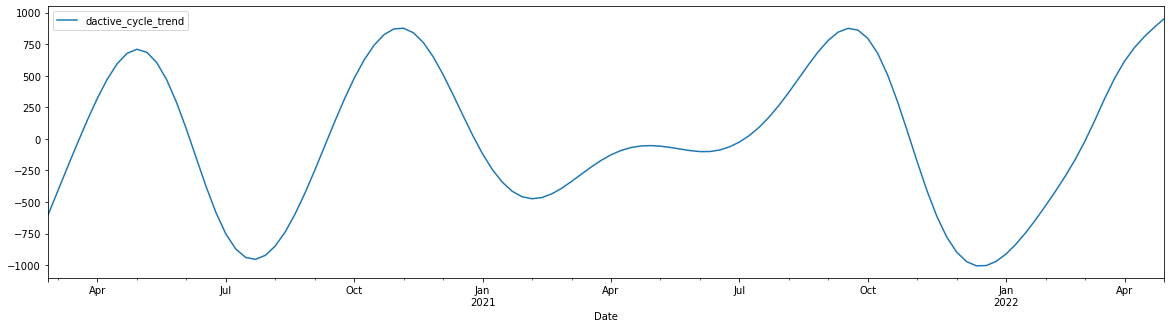

In [29]:
dactive_cycle, dactive_trend = sm.tsa.filters.hpfilter(data['dactive'], 2500)
dactive_cycle2, dactive_trend2 = sm.tsa.filters.hpfilter(dactive_cycle, 500)

pd.concat([dactive_trend2], axis='columns').plot(figsize=(20,5))
plt.show()

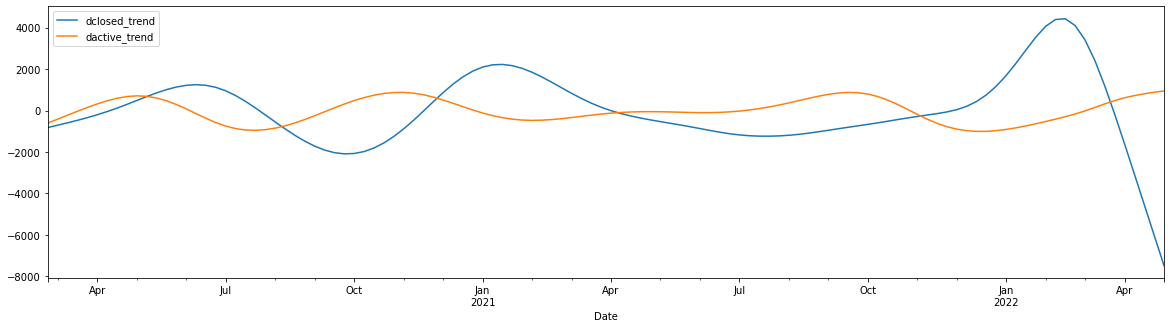

In [30]:
pd.concat([(dclosed_trend2).rename('dclosed_trend'), (dactive_trend2).rename('dactive_trend')], axis='columns').plot(figsize=(20,5))
plt.show()

In [31]:
pd.concat([(dclosed_trend2).rename('dclosed_trend'), (dactive_trend2).rename('dactive_trend')], axis='columns').to_excel('filter.xlsx')